## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [182]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [183]:
df = pd.read_csv('../../../data/clean/btc_open.csv')
df.pop('volume')
df.pop('high')
df.pop('low')
df.pop('close')
df.pop('adjclose')
df = df.reset_index()
df['formatted_date'] = pd.to_datetime(df['formatted_date']).values.astype(np.int64)
df.set_index("formatted_date",inplace=True)
df.pop('index')
df.pop('Unnamed: 0')
df_open = df['open'].values.reshape(-1, 1)

df

,open
formatted_date,
1546300800000000000,3849.216309
1546387200000000000,3931.048584
1546473600000000000,3832.040039
1546560000000000000,3851.973877
1546646400000000000,3836.519043
...,...
1681948800000000000,28249.230469
1682035200000000000,27265.894531
1682121600000000000,27816.144531


# Chuẩn hóa dữ liệu

In [184]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['open'] = arima_sc.fit_transform(df_open)
df_scaled

,open
formatted_date,
1546300800000000000,-1.164542
1546387200000000000,-1.159711
1546473600000000000,-1.165556
1546560000000000000,-1.164379
1546646400000000000,-1.165292
...,...
1681948800000000000,0.276014
1682035200000000000,0.217959
1682121600000000000,0.250445


# Vẽ đồ thị

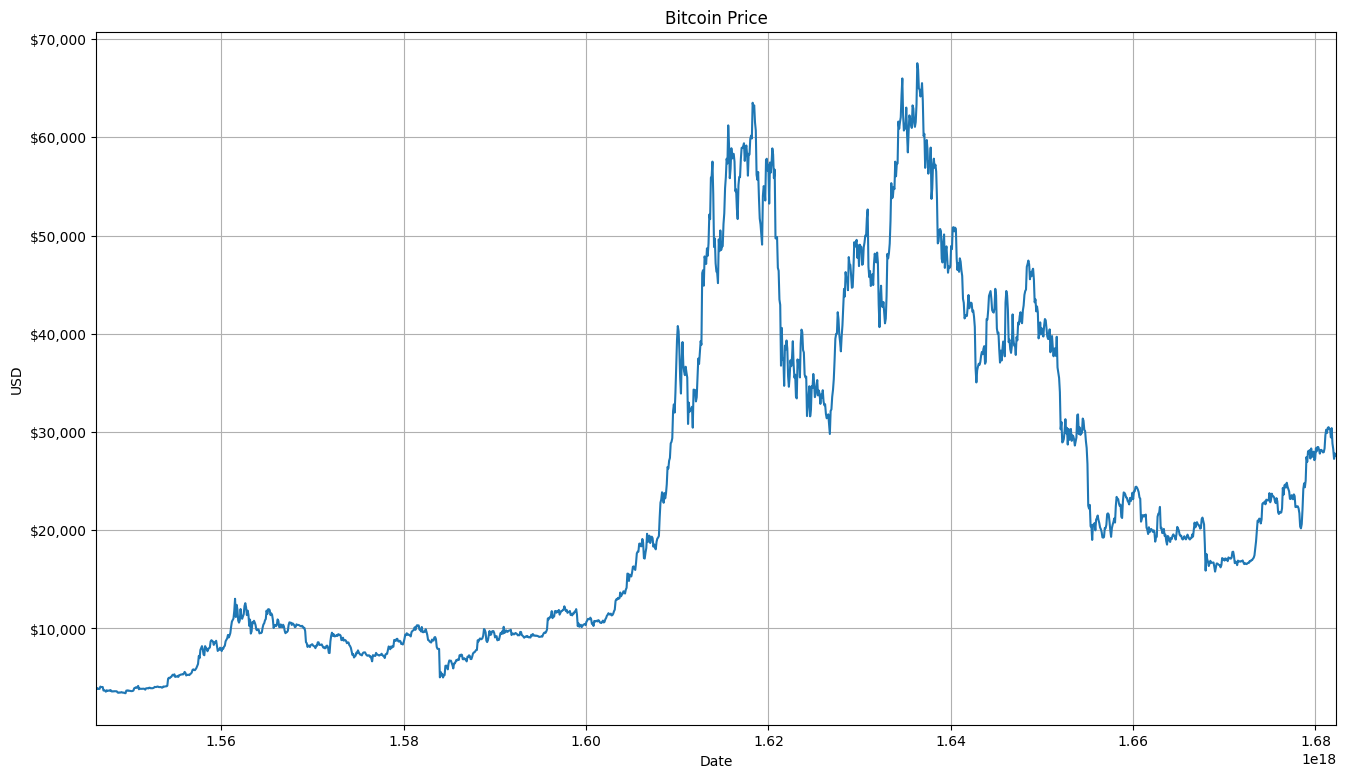

In [185]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [186]:
train, test = df_scaled[:(int)(len(df_scaled) * 1)], df_scaled[(int)(len(df_scaled) * 1):]
index_test = df_scaled.index[:(int)(len(df_scaled) * 1)]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (1575, 1)
test shape:  (0, 1)


# Hàm kiểm định chuỗi dừng

In [187]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [188]:
adf_test(train['open'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic          -1.598064
p-value                      0.484566
Number of lags used          9.000000
Number of observations    1565.000000
critical value (1%)         -3.434535
critical value (5%)         -2.863389
critical value (10%)        -2.567754
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

<Axes: xlabel='formatted_date'>

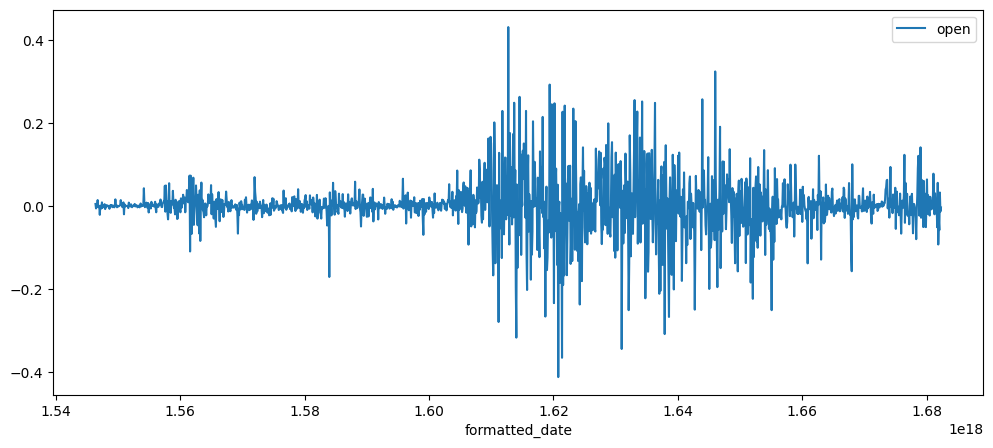

In [189]:
diff_1 = train.dropna().diff()
diff_1.plot(figsize=(12,5))

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [190]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic       -1.254381e+01
p-value                   2.283697e-23
Number of lags used       8.000000e+00
Number of observations    1.565000e+03
critical value (1%)      -3.434535e+00
critical value (5%)      -2.863389e+00
critical value (10%)     -2.567754e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [191]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [192]:
import pickle
arima_model = ArimaModel(train)
arima_model.summary()
with open("../../../models/open/arima_model.pkl", "wb") as f:
        pickle.dump(arima_model, f)
    

    
    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4163.095, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4168.149, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4168.160, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4168.124, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4169.849, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4166.200, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.613 seconds


# Dự đoán trên tập test

In [193]:
pred = arima_model.predict(len(train))
pred


1575    0.23349
1576    0.23349
1577    0.23349
1578    0.23349
1579    0.23349
         ...   
3145    0.23349
3146    0.23349
3147    0.23349
3148    0.23349
3149    0.23349
Length: 1575, dtype: float64

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [194]:
inv_test = arima_sc.inverse_transform(train.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

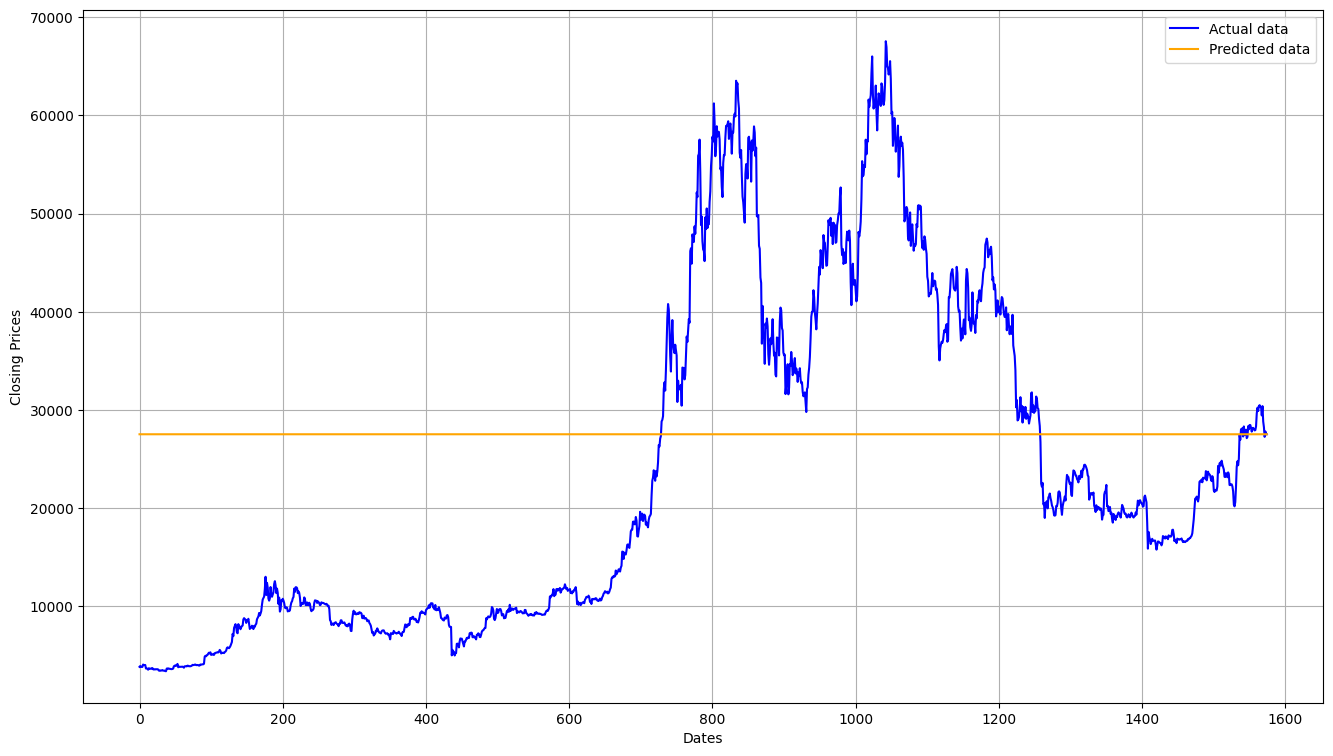

In [195]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [196]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 15539.38
MAPE: 137.21%
MSE: 302533460.17
RMSE: 17393.49
R2: -0.05


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [197]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
formatted_date,,,
1546300800000000000,3849.216309,27528.955078,-23679.738770
1546387200000000000,3931.048584,27528.955078,-23597.906494
1546473600000000000,3832.040039,27528.955078,-23696.915039
1546560000000000000,3851.973877,27528.955078,-23676.981201
1546646400000000000,3836.519043,27528.955078,-23692.436035
...,...,...,...
1681948800000000000,28249.230469,27528.955078,720.275391
1682035200000000000,27265.894531,27528.955078,-263.060547
1682121600000000000,27816.144531,27528.955078,287.189453


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [198]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
formatted_date,,,
1546300800000000000,3849.216309,27528.955078,-23679.738770
1546387200000000000,3931.048584,27528.955078,-23597.906494
1546473600000000000,3832.040039,27528.955078,-23696.915039
1546560000000000000,3851.973877,27528.955078,-23676.981201
1546646400000000000,3836.519043,27528.955078,-23692.436035
...,...,...,...
1681948800000000000,28249.230469,27528.955078,720.275391
1682035200000000000,27265.894531,27528.955078,-263.060547
1682121600000000000,27816.144531,27528.955078,287.189453


# Vẽ đồ thị thể hiện sai số

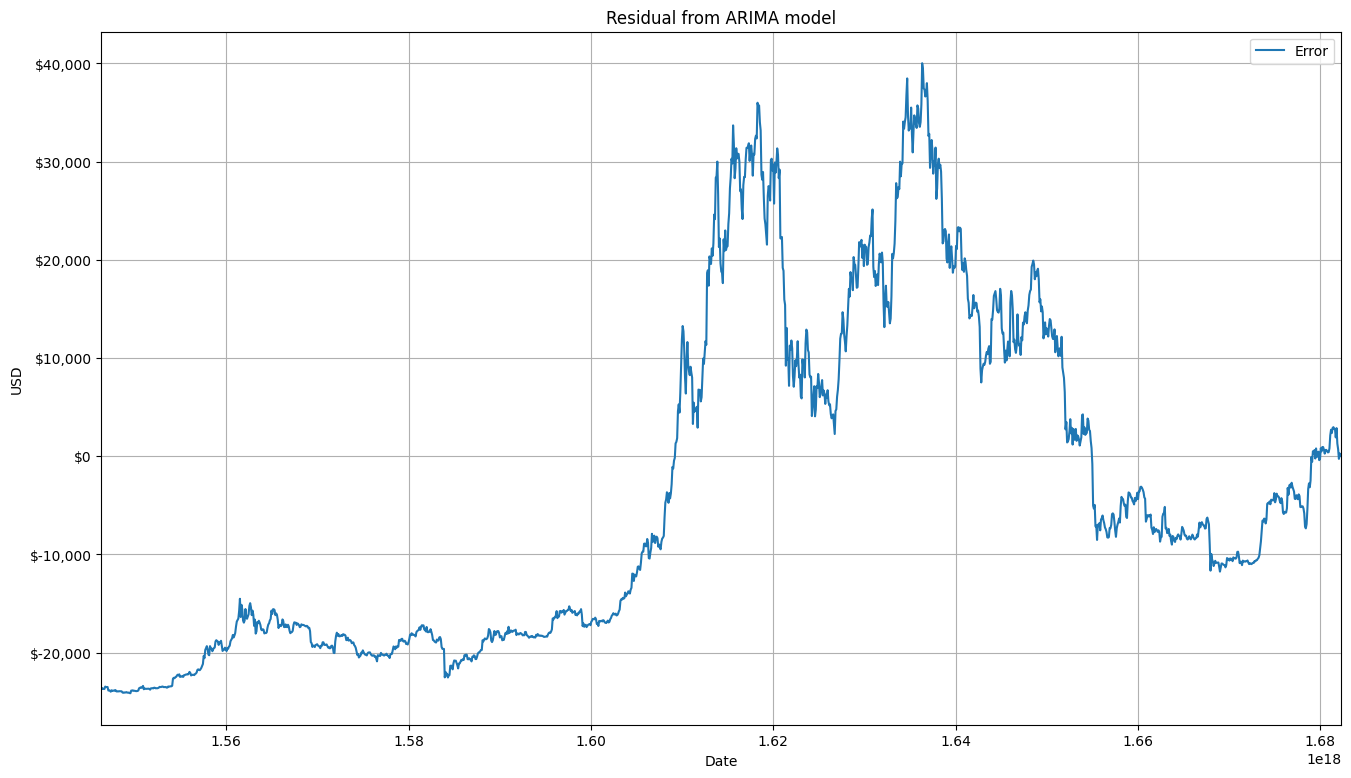

In [199]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [200]:
error = np.array(error)
error

array([[-23679.73876953],
       [-23597.90649414],
       [-23696.91503906],
       ...,
       [   287.18945312],
       [    62.77539062],
       [     0.        ]])

In [201]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (1572, 3, 1)
y_train (1572, 1)


In [202]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("../../../models/open/lstm.h5")

Epoch 1/300
50/50 [==============================] - 4s 4ms/step - loss: 237122672.0000
Epoch 2/300
50/50 [==============================] - 0s 4ms/step - loss: 66918372.0000
Epoch 3/300
50/50 [==============================] - 0s 4ms/step - loss: 2908499.7500
Epoch 4/300
50/50 [==============================] - 0s 4ms/step - loss: 3378741.7500
Epoch 5/300
50/50 [==============================] - 0s 4ms/step - loss: 4631898.0000
Epoch 6/300
50/50 [==============================] - 0s 4ms/step - loss: 2967770.5000
Epoch 7/300
50/50 [==============================] - 0s 4ms/step - loss: 2232625.7500
Epoch 8/300
50/50 [==============================] - 0s 4ms/step - loss: 2286200.7500
Epoch 9/300
50/50 [==============================] - 0s 4ms/step - loss: 2191307.7500
Epoch 10/300
50/50 [==============================] - 0s 4ms/step - loss: 2193523.2500
Epoch 11/300
50/50 [==============================] - 0s 5ms/step - loss: 2227242.2500
Epoch 12/300
50/50 [=============================

In [203]:
model = load_model("../../../models/open/lstm.h5")
error_pred = model.predict(x_train)
error_pred

50/50 [==============================] - 0s 2ms/step


array([[-2.4402504e+04],
       [-2.4410609e+04],
       [-2.4413408e+04],
       ...,
       [ 2.5152705e+02],
       [ 5.7084591e+01],
       [-3.8866110e+00]], dtype=float32)

In [204]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
formatted_date,,,,
1546300800000000000,3849.216309,27528.955078,-23679.738770,-24402.503906
1546387200000000000,3931.048584,27528.955078,-23597.906494,-24410.609375
1546473600000000000,3832.040039,27528.955078,-23696.915039,-24413.408203
1546560000000000000,3851.973877,27528.955078,-23676.981201,-24200.769531
1546646400000000000,3836.519043,27528.955078,-23692.436035,-24195.238281
...,...,...,...,...
1681689600000000000,29449.091797,27528.955078,1920.136719,1699.264404
1681776000000000000,30394.187500,27528.955078,2865.232422,-107.091927
1681862400000000000,28823.683594,27528.955078,1294.728516,251.527054


In [205]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
formatted_date,,,,,
1546300800000000000,3849.216309,27528.955078,-23679.738770,-24402.503906,3126.451172
1546387200000000000,3931.048584,27528.955078,-23597.906494,-24410.609375,3118.345703
1546473600000000000,3832.040039,27528.955078,-23696.915039,-24413.408203,3115.546875
1546560000000000000,3851.973877,27528.955078,-23676.981201,-24200.769531,3328.185547
1546646400000000000,3836.519043,27528.955078,-23692.436035,-24195.238281,3333.716797
...,...,...,...,...,...
1681689600000000000,29449.091797,27528.955078,1920.136719,1699.264404,29228.219482
1681776000000000000,30394.187500,27528.955078,2865.232422,-107.091927,27421.863152
1681862400000000000,28823.683594,27528.955078,1294.728516,251.527054,27780.482132


# Vẽ đồ thị

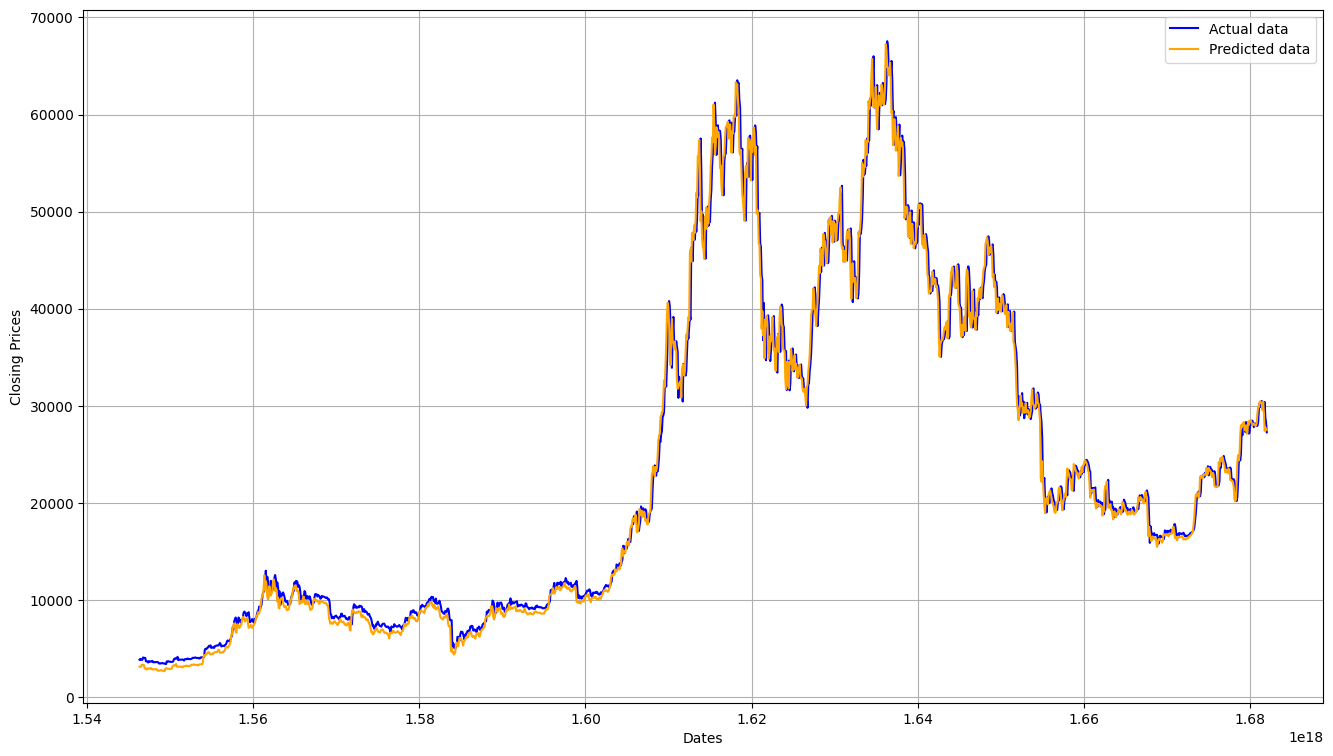

In [206]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [207]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1028.25
MAPE: 5.76%
MSE: 2278965.42
RMSE: 1509.62
R2: 0.99
